In [1]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import itertools
import tensorflow_probability as tfp
import sys
rng = jax.random.PRNGKey(0)

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Simulator in JAX

In [2]:
θ_fid = np.array([0., 1.])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [3]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(key, shape=simulator_args["input shape"])
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, Σ)

In [4]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return np.stack(jax.jacrev(simulator, argnums=1)(rng, θ, simulator_args), -1)

In [5]:
n_statistics = 2

In [6]:
def get_summary_statistics(simulation):
    return np.stack([np.mean(simulation, -1), np.std(simulation, -1)], -1)

In [7]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, simulator_args=simulator_args)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


# Model in STAX

In [8]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.
ϵ = 0.01
α = - np.log(ϵ * (λ - 1.) + ϵ**2. / (1 + ϵ)) / ϵ

In [9]:
rng, key = jax.random.split(rng)
initialiser, model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))
_, initial_w = initialiser(key, input_shape)

In [10]:
opt_initialiser, update_opt, get_parameters = optimizers.adam(step_size=1e-3)

# Data for ABC example

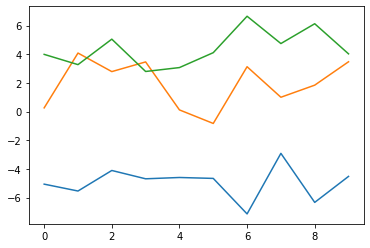

In [11]:
rng, key = jax.random.split(rng)
target_data = simulator(key, (np.array([-5, 2, 4]), np.array([2., 5., 1.])), simulator_args=simulator_args)
plt.plot(target_data.T);

In [12]:
abc_samples = int(1e7)
rng, key = jax.random.split(rng)
μ_abc = jax.random.uniform(key, shape=(abc_samples,), minval=-10.0, maxval=10.0)
rng, key = jax.random.split(rng)
Σ_abc = jax.random.uniform(key, shape=(abc_samples,), minval=0.0, maxval=10.0)
rng, key = jax.random.split(rng)
abc_simulations = simulator(key, (μ_abc, Σ_abc), simulator_args=simulator_args)

In [13]:
μ_range = np.linspace(-10., 10, 100)
Σ_range = np.linspace(0., 10., 100)
X, Y = np.meshgrid(μ_range, Σ_range)

# Base functions

### IMNN

In [14]:
@jax.jit
def fit(opt_state, λ, α, rng=None, max_detF=0., patience=100, min_iterations=1000, max_iterations=int(1e5)):
    def cond(inputs):
        return np.logical_and(
            np.less(inputs[-2], patience),
            np.less(inputs[-3], max_iterations))
    def body(inputs):
        def true_cond(inputs):
            patience_counter, counter, detF, max_detF, w, best_w = inputs
            return (0, counter, detF, detF, w, w)
        def false_cond(inputs):
            def true_sub_cond(patience_counter):
                return patience_counter + 1
            def false_sub_cond(patience_counter):
                return patience_counter
            patience_counter, counter, detF, max_detF, w, best_w = inputs
            patience_counter = jax.lax.cond(
                np.greater(counter, min_iterations), 
                true_sub_cond, 
                false_sub_cond, 
                patience_counter)
            return (patience_counter, counter, detF, max_detF, w, best_w)
        opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter, patience_counter, rng = inputs
        if rng is not None:
            rng, training_key, validation_key = jax.random.split(rng, num=3)
        else:
            training_key = None
            validation_key = None
        w = get_parameters(opt_state)
        opt_state = update_opt(counter, jax.grad(loss, argnums=1)(training_key, w, λ, α), opt_state)
        detF_, detC_, detinvC_ = get_detF(validation_key, w)
        detF_arr = jax.ops.index_update(detF_arr, jax.ops.index[counter], detF_)
        detC_arr = jax.ops.index_update(detC_arr, jax.ops.index[counter], detC_)
        detinvC_arr = jax.ops.index_update(detinvC_arr, jax.ops.index[counter], detinvC_)
        patience_counter, counter, detF_, max_detF, w, best_w = jax.lax.cond(
            np.greater(detF_, max_detF),
            true_cond,
            false_cond,
            (patience_counter, counter, detF_, max_detF, w, best_w))
        return (opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter + 1, patience_counter, rng)

    detF_arr = np.zeros(max_iterations); detC_arr = np.zeros(max_iterations); detinvC_arr = np.zeros(max_iterations)
    patience_counter = 0
    counter = 0
    best_w = get_parameters(opt_state)
    results = (opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter, patience_counter, rng)
    return jax.lax.while_loop(cond, body, results)

### Plotting

In [15]:

    
def get_levels(posterior, domain, levels=[0.68, 0.95]):
    array = np.sort(posterior.flatten())[::-1]
    cdf = np.cumsum(array * domain[0] * domain[1])
    value = []
    for level in levels[::-1]:
        this_value = array[np.argmin(np.abs(cdf - level))]
        if len(value) == 0:
            value.append(this_value)
        elif this_value <= value[-1]:
            break
        else:
            value.append(this_value)
    if value[-1] != array.max():
        value.append(array.max())
    return value

def corner_plot(target_summaries, GA, GA_μ, GA_Σ, abc_distances, ϵ):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    ax[0, 0].set_xlim([μ_range[0], μ_range[-1]])
    ax[0, 0].set_xticks([])
    ax[1, 0].set_xlim([μ_range[0], μ_range[-1]])
    ax[1, 0].set_ylim([Σ_range[0], Σ_range[-1]])
    ax[1, 1].set_ylim([Σ_range[0], Σ_range[-1]])
    ax[1, 1].set_yticks([])
    ax[1, 0].set_xlabel(r"$\mu$")
    ax[1, 0].set_ylabel(r"$\Sigma$")
    ax[0, 1].axis("off")
    colours = ["Blues", "Oranges", "Greens"]
    for i in range(target_summaries.shape[0]):
        ax[0, 0].plot(μ_range, GA_μ[:, i], linewidth=2, linestyle="dashed", color="C{}".format(i))
        ax[0, 0].axvline(target_summaries[i, 0], linewidth=1, linestyle="dotted", color="C{}".format(i))
        ax[0, 0].hist(μ_abc[abc_distances[i] < ϵ], bins=25, histtype="step", density=True, linewidth=2, color="C{}".format(i))
        ax[1, 0].contourf(μ_range, Σ_range, GA[i], cmap=colours[i], levels=get_levels(GA[i], (μ_range[1] - μ_range[0], Σ_range[1] - Σ_range[0])))
        ax[1, 0].scatter(μ_abc[abc_distances[i] < ϵ], Σ_abc[abc_distances[i] < ϵ], s=5, color="C{}".format(i))
        ax[1, 0].axvline(target_summaries[i, 0], linewidth=1, linestyle="dotted", color="C{}".format(i))
        ax[1, 0].axhline(target_summaries[i, 1], linewidth=1, linestyle="dotted", color="C{}".format(i))
        ax[1, 1].plot(GA_Σ[:, i], Σ_range, linewidth=2, linestyle="dashed", color="C{}".format(i))
        ax[1, 1].hist(Σ_abc[abc_distances[i] < ϵ], bins=25, histtype="step", density=True, linewidth=2, orientation='horizontal', color="C{}".format(i))
        ax[1, 1].axhline(target_summaries[i, 1], linewidth=1, linestyle="dotted", color="C{}".format(i))

# Simulations on the fly

#### Globals
##### For calculating loss
- `model`
- `simulator`
- `θ_fid`
- `n_summaries`
- `n_s`
- `n_d`
##### For fit
- `opt_initialiser` 
- `update_opt`
- `get_parameters`
- `loss`
- `get_detF`

In [16]:
@jax.jit
def loss(rng, w, λ, α):
    def summariser(rng, w, θ):
        return model(w, simulator(rng, θ, simulator_args=simulator_args))
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    C = np.cov(get_summaries(rng), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)
    lndetF = np.linalg.slogdet(F)
    lndetF = lndetF[0] * lndetF[1]
    Λ2 = np.linalg.norm(C - np.eye(n_summaries)) + np.linalg.norm(invC - np.eye(n_summaries))
    r = λ * Λ2 / (Λ2 + np.exp(-α * Λ2))
    return - lndetF + r * Λ2

@jax.jit
def get_detF(rng, w):
    def summariser(rng, w, θ):
        return model(w, simulator(rng, θ, simulator_args=simulator_args))
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    C = np.cov(get_summaries(rng), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    return np.linalg.det(np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)), np.linalg.det(C), np.linalg.det(invC)

@jax.jit
def get_F_stats(rng, w):
    def summariser(rng, w, θ):
        return model(w, simulator(rng, θ, simulator_args=simulator_args))
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    summaries = get_summaries(rng)
    μ = np.mean(summaries, 0)
    C = np.cov(summaries, rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    return np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ), C, invC, μ, dμ_dθ

@jax.jit
def get_estimate(d, θ_fid, invF, μ, invC, dμ_dθ, w):
    if len(d.shape) == 1:
        return θ_fid + np.einsum("ij,kj,kl,l->i", invF, dμ_dθ, invC, model(w, d) - μ)
    else:
        return θ_fid + np.einsum("ij,kj,kl,ml->mi", invF, dμ_dθ, invC, model(w, d) - μ)

#### Initialise

In [17]:
opt_state = opt_initialiser(initial_w)
max_detF = 0.
detF = np.zeros((0,))
detC = np.zeros((0,))
detinvC = np.zeros((0,))

#### Fit

In [18]:
rng, key = jax.random.split(rng)    
opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter, _, __ = fit(opt_state, λ, α, rng=key, max_detF=max_detF)

In [19]:
final_w = get_parameters(opt_state)

#### Collect and plot

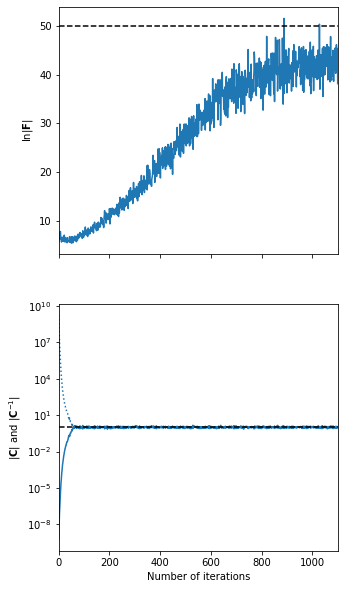

In [20]:
detF = np.hstack([detF, detF_arr[:counter]])
detC = np.hstack([detC, detC_arr[:counter]])
detinvC = np.hstack([detinvC, detinvC_arr[:counter]])
training_plot(detF, detC, detinvC)

#### ABC example
Get necessary elements for calculating quasi-MLE

In [21]:
rng, key = jax.random.split(rng)
F, C, invC, μ, dμ_dθ = get_F_stats(key, final_w)
invF = np.linalg.inv(F)

Get quasi-MLE of the target data

In [22]:
target_summaries = get_estimate(target_data, θ_fid, invF, μ, invC, dμ_dθ, final_w)

Gaussian approximation

In [23]:
GA = np.array([
    tfp.distributions.MultivariateNormalTriL(
        loc=target_summaries[i], 
        scale_tril=np.linalg.cholesky(invF)).prob(
            np.vstack([
                X.ravel(),
                Y.ravel()]).T).numpy().reshape((100, 100)) 
    for i in range(3)])
GA_μ = tfp.distributions.Normal(
    loc=target_summaries[:, 0], 
    scale=np.sqrt(invF[0, 0])).prob(np.expand_dims(μ_range, 1))
GA_Σ = tfp.distributions.Normal(
    loc=target_summaries[:, 1], 
    scale=np.sqrt(invF[1, 1])).prob(np.expand_dims(Σ_range, 1))

ABC distances

In [24]:
abc_summaries = get_estimate(abc_simulations, θ_fid, invF, μ, invC, dμ_dθ, final_w)
abc_distances = np.einsum("ijk,kl,ijl->ij", np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0), F, np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0))

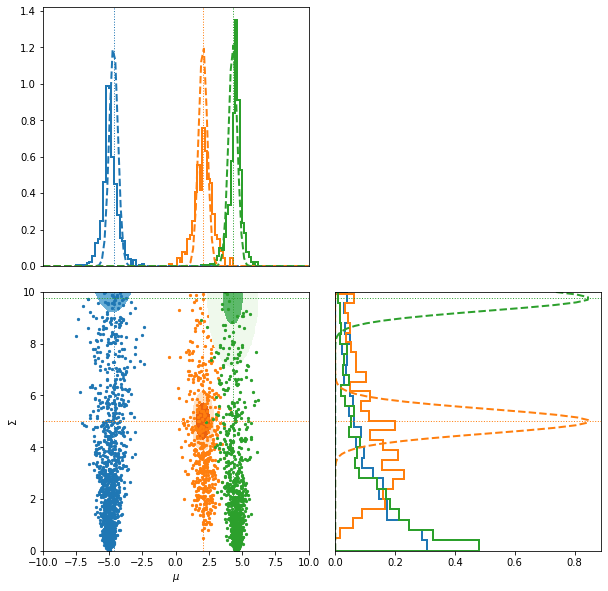

In [25]:
corner_plot(target_summaries, GA, GA_μ, GA_Σ, abc_distances, 0.005)

### With known summaries

#### Globals
##### For calculating loss
- `model`
- `simulator`
- `get_summary_statistics`
- `θ_fid`
- `n_summaries`
- `n_statistics`
- `n_s`
- `n_d`
- `λ`
- `α`
##### For fit
- `opt_initialiser` 
- `update_opt`
- `get_parameters`
- `loss`
- `get_F`

In [15]:
@jax.jit
def loss(rng, w):
    def summariser(rng, w, θ):
        simulation = simulator(rng, θ, simulator_args=simulator_args)
        return np.hstack([get_summary_statistics(simulation), model(w, simulation)])
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    C = np.cov(get_summaries(rng), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)
    lndetF = np.linalg.slogdet(F)
    lndetF = lndetF[0] * lndetF[1]
    Λ2 = np.linalg.norm(C - np.eye(n_summaries + n_statistics)) + np.linalg.norm(invC - np.eye(n_summaries + n_statistics))
    r = λ * Λ2 / (Λ2 + np.exp(-α * Λ2))
    return - lndetF + r * Λ2

@jax.jit
def get_detF(rng, w):
    def summariser(rng, w, θ):
        simulation = simulator(rng, θ, simulator_args=simulator_args)
        return np.hstack([get_summary_statistics(simulation), model(w, simulation)])
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    C = np.cov(get_summaries(rng), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    return np.linalg.det(np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)), np.linalg.det(C), np.linalg.det(invC)

@jax.jit
def get_F_stats(rng, w):
    def summariser(rng, w, θ):
        simulation = simulator(rng, θ, simulator_args=simulator_args)
        return np.hstack([get_summary_statistics(simulation), model(w, simulation)])
    def fiducial_summariser(rng):
        return summariser(rng, w, θ_fid)
    def fiducial_summary_gradient(rng):
        return jax.jacrev(summariser, argnums=2)(rng, w, θ_fid)
    def get_summaries(rng):
        keys = np.array(jax.random.split(rng, num=n_s))
        return jax.vmap(fiducial_summariser)(keys)
    def get_derivatives(rng):
        keys = np.array(jax.random.split(rng, num=n_d))
        return jax.vmap(fiducial_summary_gradient)(keys)
    summaries = get_summaries(rng)
    μ = np.mean(summaries, 0)
    C = np.cov(summaries, rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(rng), 0)
    return np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ), C, invC, μ, dμ_dθ

@jax.jit
def get_estimate(d, θ_fid, invF, μ, invC, dμ_dθ, w):
    if len(d.shape) == 1:
        return θ_fid + np.einsum("ij,kj,kl,l->i", invF, dμ_dθ, invC, np.hstack([get_summary_statistics(d), model(w, d)]) - μ)
    else:
        return θ_fid + np.einsum("ij,kj,kl,ml->mi", invF, dμ_dθ, invC, np.hstack([get_summary_statistics(d), model(w, d)]) - μ)

#### Initialise

In [16]:
opt_state = opt_initialiser(initial_w)
max_detF = 0.
detF = np.zeros((0,))
detC = np.zeros((0,))
detinvC = np.zeros((0,))

#### Fit

In [17]:
rng, key = jax.random.split(rng)    
opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter, _, __ = fit(opt_state, rng=key, max_detF=max_detF)

In [18]:
final_w = get_parameters(opt_state)

#### Collect and plot

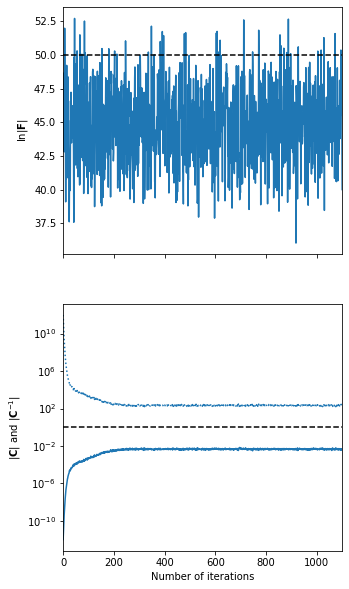

In [19]:
detF = np.hstack([detF, detF_arr[:counter]])
detC = np.hstack([detC, detC_arr[:counter]])
detinvC = np.hstack([detinvC, detinvC_arr[:counter]])
training_plot(detF, detC, detinvC)

#### ABC example
Get necessary elements for calculating quasi-MLE

In [21]:
rng, key = jax.random.split(rng)
F, C, invC, μ, dμ_dθ = get_F_stats(key, final_w)
invF = np.linalg.inv(F)

Get quasi-MLE of the target data

In [22]:
target_summaries = get_estimate(target_data, θ_fid, invF, μ, invC, dμ_dθ, final_w)

Gaussian approximation

In [23]:
GA = np.array([
    tfp.distributions.MultivariateNormalTriL(
        loc=target_summaries[i], 
        scale_tril=np.linalg.cholesky(invF)).prob(
            np.vstack([
                X.ravel(),
                Y.ravel()]).T).numpy().reshape((100, 100)) 
    for i in range(3)])
GA_μ = tfp.distributions.Normal(
    loc=target_summaries[:, 0], 
    scale=np.sqrt(invF[0, 0])).prob(np.expand_dims(μ_range, 1))
GA_Σ = tfp.distributions.Normal(
    loc=target_summaries[:, 1], 
    scale=np.sqrt(invF[1, 1])).prob(np.expand_dims(Σ_range, 1))

ABC distances

In [24]:
abc_summaries = get_estimate(abc_simulations, θ_fid, invF, μ, invC, dμ_dθ, final_w)
abc_distances = np.einsum("ijk,kl,ijl->ij", np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0), F, np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0))

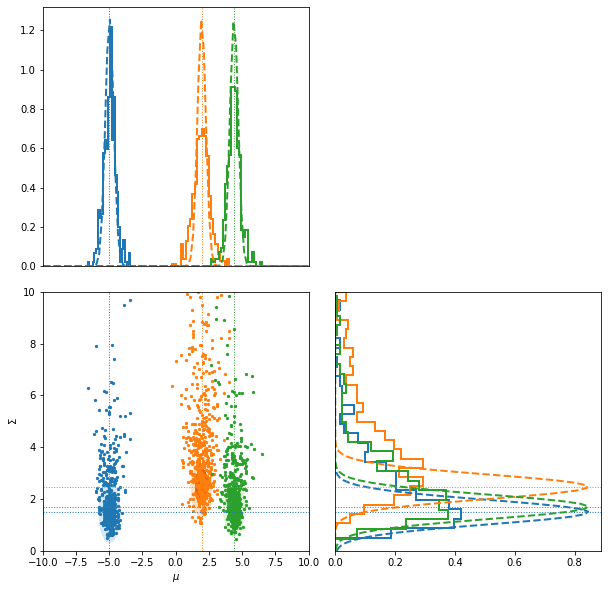

In [25]:
corner_plot(target_summaries, GA, GA_μ, GA_Σ, abc_distances, 0.01)

# Premade simulations with gradients

#### Globals
##### For calculating loss
- `model`
- `imnn_fiducial_simulations`
- `imnn_simulation_gradients`
- `θ_fid`
- `n_summaries`
- `n_s`
- `n_d`
- `λ`
- `α`
##### For fit
- `opt_initialiser` 
- `update_opt`
- `get_parameters`
- `loss`
- `get_detF`
- `get_F_stats`

In [20]:
@jax.jit
def loss(_, w):
    def get_summaries():
        return model(w, imnn_fiducial_simulations)
    def get_derivatives():
        def fn(simulation):
            return np.stack(jax.jacrev(model, argnums=1)(w, simulation), -1)
        dx_dd = jax.vmap(fn)(imnn_fiducial_simulations)
        return np.einsum("i...j,i...k->ijk", dx_dd, imnn_simulation_gradients)
    C = np.cov(get_summaries(), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(), 0)
    F = np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)
    lndetF = np.linalg.slogdet(F)
    lndetF = lndetF[0] * lndetF[1]
    Λ2 = np.linalg.norm(C - np.eye(n_summaries)) + np.linalg.norm(invC - np.eye(n_summaries))
    r = λ * Λ2 / (Λ2 + np.exp(-α * Λ2))
    return - lndetF + r * Λ2

@jax.jit
def get_detF(_, w):
    def get_summaries():
        return model(w, imnn_fiducial_simulations)
    def get_derivatives():
        def fn(simulation):
            return np.stack(jax.jacrev(model, argnums=1)(w, simulation), -1)
        dx_dd = jax.vmap(fn)(imnn_fiducial_simulations)
        return np.einsum("i...j,i...k->ijk", dx_dd, imnn_simulation_gradients)
    C = np.cov(get_summaries(), rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(), 0)
    return np.linalg.det(np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ)), np.linalg.det(C), np.linalg.det(invC)

@jax.jit
def get_F_stats(_, w):
    def get_summaries():
        return model(w, imnn_fiducial_simulations)
    def get_derivatives():
        def fn(simulation):
            return np.stack(jax.jacrev(model, argnums=1)(w, simulation), -1)
        dx_dd = jax.vmap(fn)(imnn_fiducial_simulations)
        return np.einsum("i...j,i...k->ijk", dx_dd, imnn_simulation_gradients)
    summaries = get_summaries()
    μ = np.mean(summaries, 0)
    C = np.cov(summaries, rowvar=False)
    invC = np.linalg.inv(C)
    dμ_dθ = np.mean(get_derivatives(), 0)
    return np.einsum("ij,ik,kl->jl", dμ_dθ, invC, dμ_dθ), C, invC, μ, dμ_dθ

@jax.jit
def get_estimate(d, θ_fid, invF, μ, invC, dμ_dθ, w):
    if len(d.shape) == 1:
        return θ_fid + np.einsum("ij,kj,kl,l->i", invF, dμ_dθ, invC, model(w, d) - μ)
    else:
        return θ_fid + np.einsum("ij,kj,kl,ml->mi", invF, dμ_dθ, invC, model(w, d) - μ)

In [21]:
rng, *keys = jax.random.split(rng, num=n_s+1)
imnn_fiducial_training_simulations = jax.vmap(lambda key, μ, Σ: simulator(key, (μ, Σ), simulator_args=simulator_args))(np.array(keys), np.repeat(θ_fid[0], n_s), np.repeat(θ_fid[1], n_s))
imnn_training_simulation_gradients = jax.vmap(lambda key, μ, Σ: simulator_gradient(key, (μ, Σ), simulator_args=simulator_args))(np.array(keys), np.repeat(θ_fid[0], n_s), np.repeat(θ_fid[1], n_s))

#### Initialise

In [22]:
opt_state = opt_initialiser(initial_w)
max_detF = 0.
detF = np.zeros((0,))
detC = np.zeros((0,))
detinvC = np.zeros((0,))

#### Fit

In [23]:
opt_state, max_detF, best_w, detF_arr, detC_arr, detinvC_arr, counter, _, __ = fit(opt_state, max_detF=max_detF)

#### Collect and plot

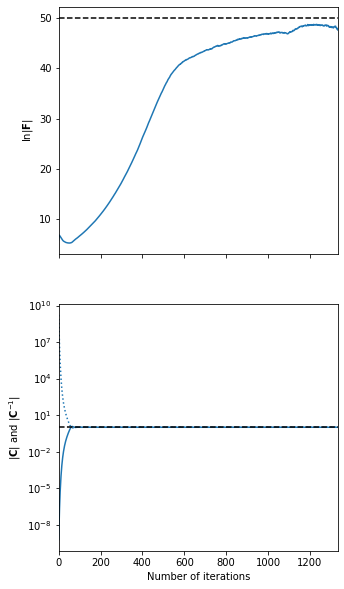

In [24]:
detF = np.hstack([detF, detF_arr[:counter]])
detC = np.hstack([detC, detC_arr[:counter]])
detinvC = np.hstack([detinvC, detinvC_arr[:counter]])
training_plot(detF, detC, detinvC)

#### ABC example
Get necessary elements for calculating quasi-MLE

In [18]:
rng, key = jax.random.split(rng)
F, C, invC, μ, dμ_dθ = get_F_stats(key, best_w)
invF = np.linalg.inv(F)

Get quasi-MLE of the target data

In [19]:
target_summaries = get_estimate(target_data, θ_fid, invF, μ, invC, dμ_dθ, best_w)

Gaussian approximation

In [20]:
GA = np.array([
    tfp.distributions.MultivariateNormalTriL(
        loc=target_summaries[i], 
        scale_tril=np.linalg.cholesky(invF)).prob(
            np.vstack([
                X.ravel(),
                Y.ravel()]).T).numpy().reshape((100, 100)) 
    for i in range(3)])
GA_μ = tfp.distributions.Normal(
    loc=target_summaries[:, 0], 
    scale=np.sqrt(invF[0, 0])).prob(np.expand_dims(μ_range, 1))
GA_Σ = tfp.distributions.Normal(
    loc=target_summaries[:, 1], 
    scale=np.sqrt(invF[1, 1])).prob(np.expand_dims(Σ_range, 1))

ABC distances

In [21]:
abc_summaries = get_estimate(abc_simulations, θ_fid, invF, μ, invC, dμ_dθ, best_w)
abc_distances = np.einsum("ijk,kl,ijl->ij", np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0), F, np.expand_dims(target_summaries, 1) - np.expand_dims(abc_summaries, 0))

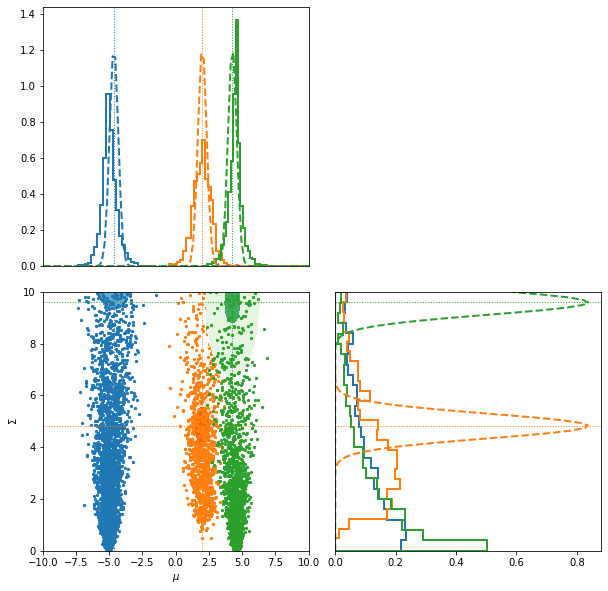

In [22]:
corner_plot(target_summaries, GA, GA_μ, GA_Σ, abc_distances, 0.01)

### With known summaries

# Premade simulations with numerical gradients

### With known summaries